<a href="https://colab.research.google.com/github/mohanrajmit/IDD/blob/master/seg_updated_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparation

In [12]:
!git clone https://github.com/mohanrajmit/IDD.git

Cloning into 'IDD'...
remote: Enumerating objects: 4879, done.
remote: Counting objects: 100% (4879/4879), done.
remote: Compressing objects: 100% (4491/4491), done.
remote: Total 4879 (delta 217), reused 4767 (delta 125), pack-reused 0
Receiving objects: 100% (4879/4879), 28.65 MiB | 53.84 MiB/s, done.
Resolving deltas: 100% (217/217), done.


In [0]:
import cv2
from imutils import paths

In [0]:
labels_path = paths.list_images("/content/IDD/idd20k_lite/gtFine")
labels_path = sorted(labels_path)


In [0]:
def binarylab(labels_name):
  #counter=0
  #print(labels_name.shape)
  x = np.zeros([227,320,8])
  for i in range(227):
    for j in range(320):      
      if (labels_name[i][j]==255):
        #print(counter)
        x[i,j,7]=1
      else:
        x[i,j,labels_name[i][j]]=1

  return x

In [0]:
train_labels = []
val_labels = []
train_labels_conv = []
val_labels_conv = []

import numpy as np
for imagePath in labels_path:
  #print(imagePath)
  make = imagePath.split("/")[-3]
  #print(make)
  image = cv2.imread(imagePath)
  b,g,r = cv2.split(image)
  binary_label = binarylab(r)
  if make == "train":
    train_labels.append(image)
    train_labels_conv.append(binary_label)
  else:
    val_labels.append(image)
    val_labels_conv.append(binary_label)
#print(images_path[0])

In [17]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
train_labels_conv = np.array(train_labels_conv)
val_labels_conv = np.array(val_labels_conv)
#sample= train_laebls[0]
print(train_labels.shape)

(1403, 227, 320, 3)


In [0]:
train_labels1 = train_labels_conv.reshape(1403,72640,8)
val_labels1 = val_labels_conv.reshape(204,72640,8)

In [19]:
print(train_labels1.shape)

(1403, 72640, 8)


In [0]:
images_path=paths.list_images("/content/IDD/idd20k_lite/leftImg8bit")
images_path=sorted(images_path)

In [0]:
train_images = []
val_images = []
test_images = []
import numpy as np
for imagePath in images_path:
  #print(imagePath)
  make = imagePath.split("/")[-3]
  #print(make)
  image = cv2.imread(imagePath)
  if make == "train":
    train_images.append(image)
  elif make == "test":
    test_images.append(image)
  else:
    val_images.append(image)

In [0]:
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

In [23]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

(1403, 227, 320, 3)
(404, 227, 320, 3)
(204, 227, 320, 3)


(227, 320, 3)
(227, 320, 3)


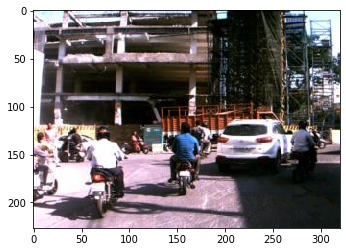

In [24]:
sample_image_label = train_labels[0]
sample_image = train_images[0]
print(sample_image_label.shape)
print(sample_image.shape)
from matplotlib import pyplot as plt
import imutils
plt.figure("original_image")
plt.imshow(imutils.opencv2matplotlib(sample_image))

In [0]:

colors = np.array([
    [128, 64, 18],      # Drivable
    [244, 35, 232],     # Non Drivable
    [220, 20, 60],      # Living Things
    [0, 0, 230],        # Vehicles
    [220, 190, 40],     # Road Side Objects
    [70, 70, 70],       # Far Objects
    [70, 130, 180],     # Sky
    [0, 0, 0]           # Misc
], dtype=np.int)

def visualize(temp, plot=True):
    r,g,b =cv2.split(temp)
    color_image = np.zeros(
        (r.shape[0], r.shape[1], 3), dtype=np.int)
    for i in range(7):
        color_image[r == i] = colors[i]

    color_image[r == 255] = colors[7]
    #plt.imshow(image_frame)
    plt.imshow(color_image)
    plt.show()

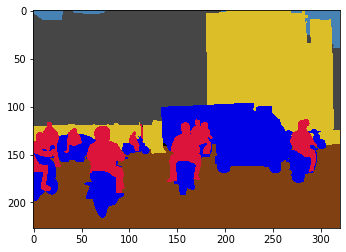

In [26]:
visualize(sample_image_label)

## Model

In [27]:
!pip install keras-radam

In [0]:
import keras.models as models
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.layers import merge
from keras_radam import RAdam

In [0]:
opt = RAdam(total_steps=5000, warmup_proportion=0.1, min_lr=1e-5)

In [0]:
from keras.layers.convolutional import Conv2D, ZeroPadding2D, UpSampling2D
from keras.layers.core import Flatten, Dense, Reshape, Permute, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.models import *
import os
from keras.layers import Lambda
import tensorflow as tf
from keras import backend as K
K.set_image_data_format('channels_last')
#from keras.backend import tf as ktf

In [0]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten


Model architecture

In [0]:
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(227, 320, 3))
# add new classifier layers
#model.summary()
flat1 = Flatten()(model.outputs)
o = Reshape((7, 10, 512))(flat1)

o = ZeroPadding2D((1,1))(o)
o = Conv2D(512,(3,3),padding='valid')(o)
o = BatchNormalization()(o)

o = UpSampling2D((2,2))(o)
o = ZeroPadding2D((1,1))(o)
o = Conv2D(512,(3,3),padding='valid')(o)
o = BatchNormalization()(o)

o = UpSampling2D((2,2))(o)
o = ZeroPadding2D((1,1))(o)
o = Conv2D(256,(3,3),padding='valid')(o)
o = BatchNormalization()(o)

o = UpSampling2D((2,2))(o)
o = ZeroPadding2D((1,1))(o)
o = Conv2D(128,(3,3),padding='valid')(o)
o = BatchNormalization()(o)

o = UpSampling2D((2, 2))(o)
o = ZeroPadding2D((1, 1))(o)
o = Conv2D(64, (3, 3), padding='valid')(o)
o = BatchNormalization()(o)
o = UpSampling2D((2, 2))(o)
o = Lambda(lambda image: tf.image.resize_images(image,(227,320)))(o)

o = Conv2D(8,(3,3),padding='same')(o)
#o_shape = Model(img_input,o).output_shape
#outputHeight = o_shape[2]
#outputWidth = o_shape[3]


#o = (Reshape((-1,outputHeight*outputWidth)))(o)
o = (Reshape((227*320,8), input_shape=(227,320,8)))(o)
#o = (Permute((2,1)))(o)
o = Activation('softmax')(o)
model = Model(model.inputs,o)
#model.summary()
#model.outputWidth = outputWidth
#model.outputHeight = outputHeight

#return  model

In [33]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 227, 320, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 160, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 80, 128)       0   

In [35]:
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

Model Training

In [36]:
nb_epoch = 100
batch_size = 16

history = model.fit(train_images, train_labels1, batch_size=batch_size,epochs=nb_epoch,verbose=1, validation_data=(val_images, val_labels1))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1403 samples, validate on 204 samples
Epoch 1/100


InvalidArgumentError: ignored

## Testing the trainied Model

In [0]:
test_path= paths.list_images("/content/IDD/idd20k_lite/leftImg8bit/test")
test_path=sorted(test_path)

In [0]:
test_images_final = []
test_images_name = []
import os
for imagePath in test_path:
  image=cv2.imread(imagePath)
  #print(imagePath)
  make = imagePath.split("/")[-1]
  filename = make[:make.rfind("_")]
  #print(filename)
  make1=imagePath.split("/")[-2]  
  directory="output/"+ make1
  if not os.path.exists(directory):
    os.makedirs(directory)
  image_name = "output/"+ make1+"/"+filename+"_label.png"
  test_images_final.append(image)
  test_images_name.append(image_name)


In [0]:
test_images_final = np.array(test_images_final)

## Model Prediction

In [0]:
output = model.predict_proba(test_images_final, verbose=0)
output = output.reshape(output.shape[0],227,320,8)

In [0]:
print(output.shape)
print(output.shape[0])

In [0]:
for i in range(output.shape[0]):
  #print(i)
  sample_pred = np.argmax(output[i],axis=-1)
  #print(sample_pred.shape)
  #image_name = "output/" + str(image_counter) + ".png"
  sample_pred[sample_pred == 7] = 255
  #color_image[label_map == 255] = colors[7]
  cv2.imwrite(test_images_name[i],sample_pred)

Saving the results

In [0]:
!zip -r output.zip output

Download the output

In [0]:
from google.colab import files
files.download('/content/output.zip') 

In [0]:
# !sudo apt install zip unzip